In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import datetime 

from sklearn import metrics
from scipy.signal import chirp, find_peaks, peak_widths

from pysb import *
from pysb.macros import *
from pysb.integrate import Solver
from pysb.simulator import ScipyOdeSimulator

from OTR_pathway import network as mynet


In [3]:
#Simulation's Parameters
time_in     = 50    # time of the simulation in which OT starts binding OTR (seconds)
time_out    = 51    # time of the simulation in which OT stops binding OTR (seconds)
kf_fold_wt  = 1     # variable that multiplies the forward kinetic constant for the OTR-wt
kf_fold_mut = 1.5   # variable that multiplies the forward kinetic constant for the OTR-mut
ttotal      = 250   # total time of simulation (seconds)
nsteps      = 10000 # integration step

#simualtion time
t = pl.linspace(0, ttotal, num=nsteps)

#Simulation 1
simres_wt = ScipyOdeSimulator(mynet(time_in, time_out, kf_fold_wt), tspan=t).run()
OTR_wt_out = simres_wt.all

#Simulation 2
simres_mut = ScipyOdeSimulator(mynet(time_in, time_out, kf_fold_mut), tspan=t).run()
OTR_mut_out = simres_mut.all


In [4]:
#Ca ratio calculation
Ca_wt  = OTR_wt_out['obs_Ca']
Ca_mut = OTR_mut_out['obs_Ca']

time = np.take(t, np.where(t>50))[0]

Ca_curve_wt  = np.take(Ca_wt,  np.where(t>50))[0]
Ca_curve_mut = np.take(Ca_mut, np.where(t>50))[0]

Ca_peaks_wt, _  = find_peaks(Ca_curve_wt)
Ca_peaks_mut, _ = find_peaks(Ca_curve_mut)

vmax_Ca_curve_wt  = Ca_curve_wt[Ca_peaks_wt][0]*1E3
vmax_Ca_curve_mut = Ca_curve_mut[Ca_peaks_mut][0]*1E3

Ca_ratio = round(vmax_Ca_curve_mut/vmax_Ca_curve_wt, 2)
print('Calcium ratio: ', Ca_ratio)


Calcium ratio:  1.13


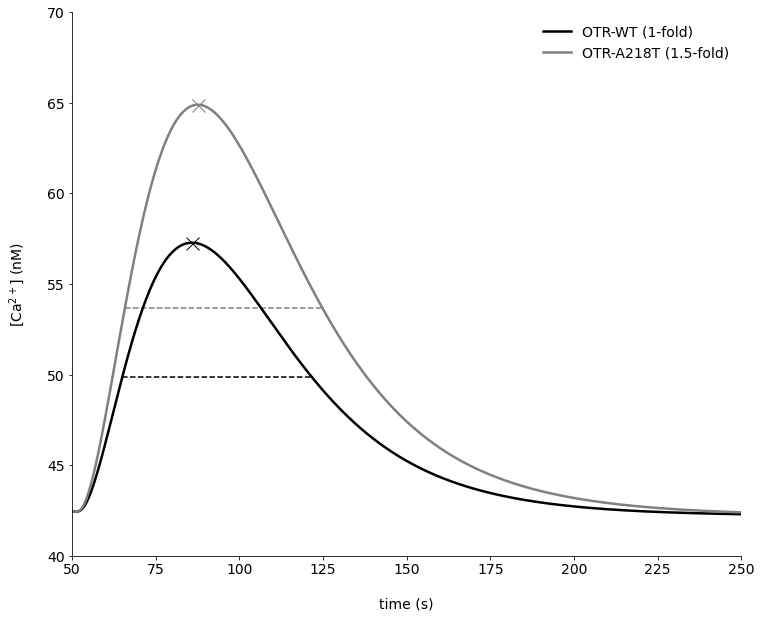

Area under the curve WT:  9.4
Area under the curve mut:  9.94
AUC_diff network:  1.06
FWHM wt:  56.63
FWHM A218T:  59.03
FWHM diff net:  1.04


In [53]:
half_wt = peak_widths(Ca_curve_wt, Ca_peaks_wt, rel_height=0.5)
half_mut = peak_widths(Ca_curve_mut, Ca_peaks_mut, rel_height=0.5)
fwhm_wt = time[int(half_wt[3])]-time[int(half_wt[2])]
fwhm_mut = time[int(half_mut[3])]-time[int(half_mut[2])]

###PLOT
pl.figure(figsize=[12,10])
time = np.take(t, np.where(t>50))[0]
plt.plot(time[Ca_peaks_wt], Ca_curve_wt[Ca_peaks_wt]*1E3, 'x',color='Black', markersize=13)
plt.hlines(half_wt[1]*1E3, time[int(half_wt[2])], time[int(half_wt[3])],linestyles='dashed', color="black")
pl.plot(time, Ca_curve_wt*1E3, color="black",linewidth=2.5,label="OTR-WT (1-fold)")

plt.plot(time[Ca_peaks_mut], Ca_curve_mut[Ca_peaks_mut]*1E3, 'x', color='grey',markersize=13)
plt.hlines(half_mut[1]*1E3,time[int(half_mut[2])], time[int(half_mut[3])], color="gray",linestyles='dashed')
pl.plot(time, Ca_curve_mut*1E3, color='gray',linewidth=2.5, label="OTR-A218T (1.5-fold)")

plt.legend(frameon=False, fontsize=14)

plt.axis(xmin=50, xmax=250, ymin=40, ymax=70)
plt.xticks(fontsize=14)
plt.yticks(np.arange(40,71,5),fontsize=14)
axes = plt.gca()
axes.set_xlabel('time (s)',fontsize=14, labelpad=20)
axes.set_ylabel('[Ca$^{2+}$] (nM)', fontsize=14, labelpad=20)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)

plt.show()

##Analysis
AUC_wt  = round(metrics.auc(time, Ca_curve_wt),2)
AUC_mut = round(metrics.auc(time, Ca_curve_mut),2)

print('Area under the curve WT: ', AUC_wt)
print('Area under the curve mut: ', AUC_mut)

AUC_diff_net = round(AUC_mut/AUC_wt,2)
print('AUC_diff network: ', AUC_diff_net)
print('FWHM wt: ', round(fwhm_wt,2))
print('FWHM A218T: ', round(fwhm_mut,2))
print('FWHM diff net: ', round(fwhm_mut/fwhm_wt,2))


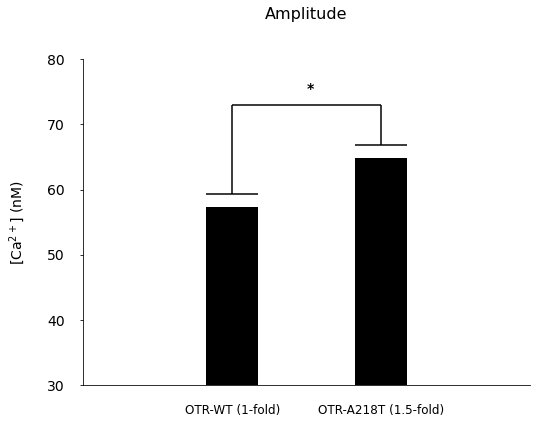

In [46]:
#Amplitude Plot
pl.figure(figsize=[8,6])

#data
x=[1,2]
plt.title('Amplitude', fontdict={'fontsize':16,'fontweight':'normal'},pad=40)
plt.bar(x, [vmax_Ca_curve_wt, vmax_Ca_curve_mut], width = 0.35, color='black' )

#axis
axes = plt.gca()
axes.set_ylabel('[Ca$^{2+}$] (nM)', fontsize=14, labelpad=20)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
plt.xticks(x, ('OTR-WT (1-fold)', 'OTR-A218T (1.5-fold)'), fontsize=12)
plt.axis(xmin=0, xmax=3, ymin=30, ymax=80)
plt.yticks(fontsize=14)

#elements
plt.hlines(vmax_Ca_curve_wt+2, 0.825, 1.175,linestyles='solid',  color="black")
plt.hlines(vmax_Ca_curve_mut+2, 1.825, 2.175,linestyles='solid',  color="black")
plt.vlines(1, vmax_Ca_curve_wt+2, vmax_Ca_curve_mut+8,linestyles='solid', color="black")
plt.vlines(2, vmax_Ca_curve_mut+2, vmax_Ca_curve_mut+8,linestyles='solid', color="black")
plt.hlines(vmax_Ca_curve_mut+8, 1, 2,linestyles='solid',  color="black")
plt.text(1.5, vmax_Ca_curve_mut+10,'*',fontdict={'fontsize':14,'fontweight':'bold'}, color='black')
plt.tick_params(bottom=False, pad=15)

plt.show()


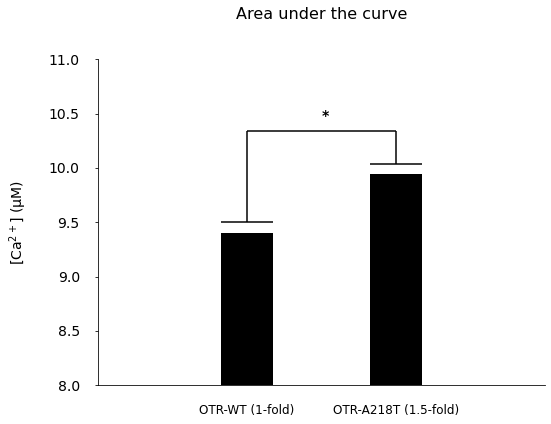

In [51]:
#AUC Plot
pl.figure(figsize=[8,6])
plt.title('Area under the curve', fontdict={'fontsize':16,'fontweight':'normal'},pad=40)

#main data
x=[1,2]
plt.bar(x, [AUC_wt, AUC_mut],width = 0.35, color='black' )
plt.xticks(x, ('OTR-WT (1-fold)', 'OTR-A218T (1.5-fold)'), fontsize=12)

#axis
axes = plt.gca()
plt.axis(xmin=0, xmax=3, ymin=8, ymax=11)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
plt.yticks(fontsize=14)
plt.tick_params(bottom=False, pad=15)
axes.set_ylabel('[Ca$^{2+}$] (µM)', fontsize=14, labelpad=20)

#elements
plt.hlines(AUC_wt+0.1, 0.825, 1.175,linestyles='solid',  color="black")
plt.hlines(AUC_mut+0.1, 1.825, 2.175,linestyles='solid',  color="black")
plt.vlines(1, AUC_wt+0.1, AUC_mut+0.4,linestyles='solid', color="black")
plt.vlines(2, AUC_mut+0.1, AUC_mut+0.4,linestyles='solid', color="black")
plt.hlines(AUC_mut+0.4, 1, 2,linestyles='solid',  color="black")
plt.text(1.5, AUC_mut+0.5,'*',fontdict={'fontsize':14,'fontweight':'bold'}, color='black')
plt.show()

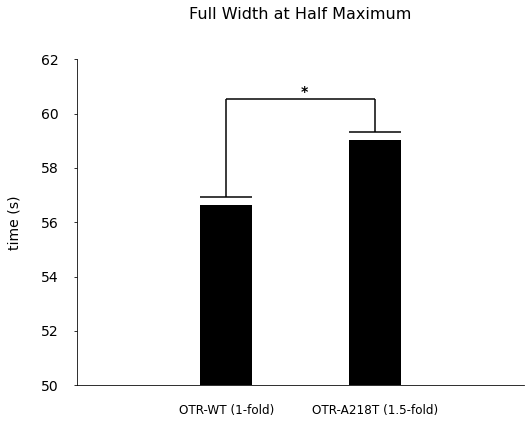

In [52]:
#FWHM Plot
pl.figure(figsize=[8,6])
plt.title('Full Width at Half Maximum', fontdict={'fontsize':16,'fontweight':'normal'},pad=40)

#data
x=[1,2]
plt.bar(x, [fwhm_wt, fwhm_mut],width = 0.35, color='black' )
plt.xticks(x, ('OTR-WT (1-fold)', 'OTR-A218T (1.5-fold)'), fontsize=12)

#axis
axes = plt.gca()
plt.axis(xmin=0, xmax=3, ymin=50, ymax=62)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
plt.yticks(fontsize=14)
plt.tick_params(bottom=False, pad=15)
axes.set_ylabel('time (s)', fontsize=14, labelpad=20)

#elements
plt.hlines(fwhm_wt+0.3, 0.825, 1.175,linestyles='solid',  color="black")
plt.hlines(fwhm_mut+0.3, 1.825, 2.175,linestyles='solid',  color="black")
plt.vlines(1, fwhm_wt+0.3, fwhm_mut+1.5,linestyles='solid', color="black")
plt.vlines(2, fwhm_mut+0.3, fwhm_mut+1.5,linestyles='solid', color="black")
plt.hlines(fwhm_mut+1.5, 1, 2,linestyles='solid', color="black")
plt.text(1.5, fwhm_mut+1.6,'*',fontdict={'fontsize':14,'fontweight':'bold'}, color='black')
plt.show()


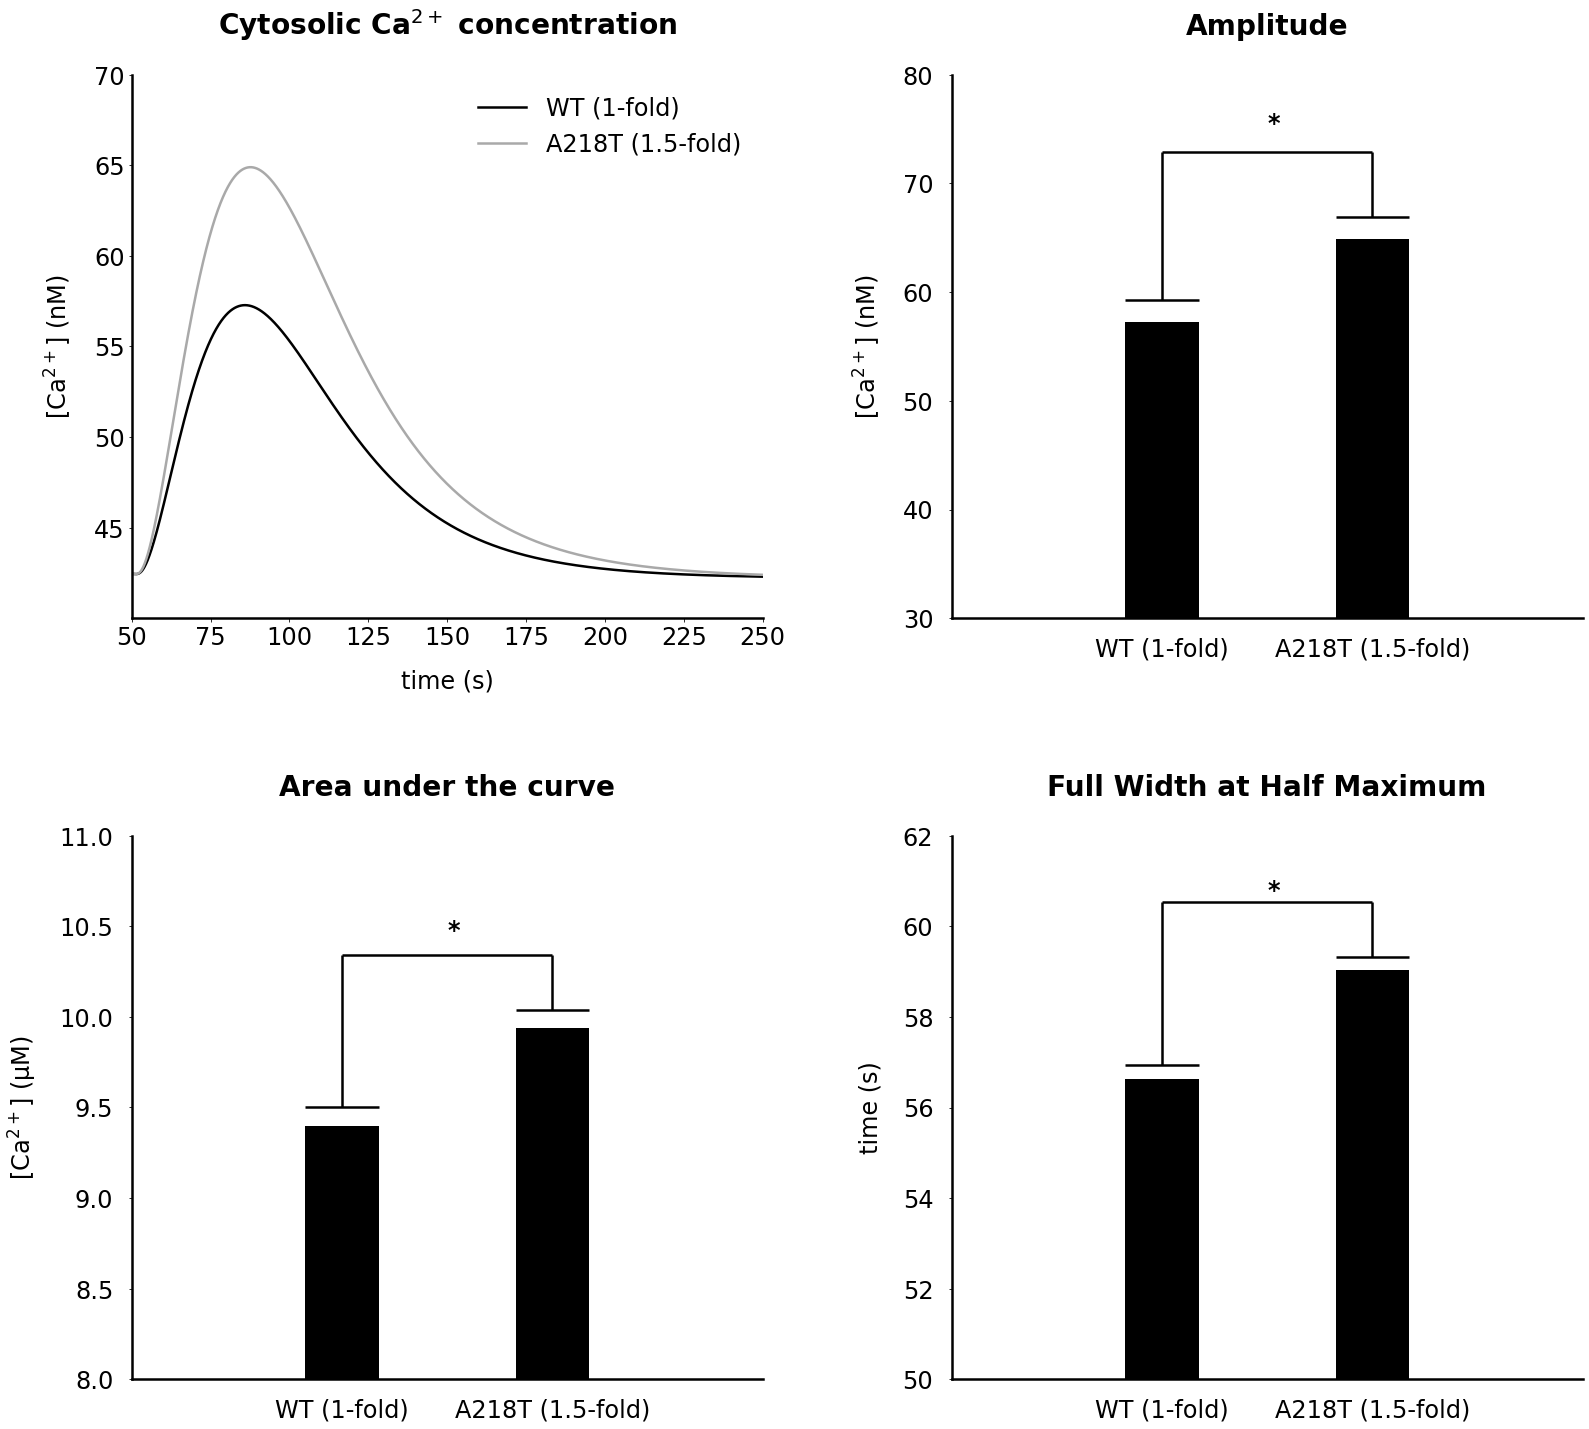

In [37]:
##Paper's Figure
pl.figure(figsize=[26,24])
plt.subplots_adjust(wspace=0.3, hspace=0.4)

###Calcium curves
plt.subplot(221)
plt.title('Cytosolic Ca$^{2+}$ concentration', fontdict={'fontsize':28,'fontweight':'bold'},pad=40)
pl.plot(time, Ca_curve_wt*1E3, color="black",linewidth=2.5,label="WT (1-fold)")
pl.plot(time, Ca_curve_mut*1E3, color='darkgrey',linewidth=2.5, label="A218T (1.5-fold)")

plt.legend(frameon=False, fontsize=24)

plt.axis(xmin=50, xmax=250, ymin=40, ymax=70)
plt.xticks(fontsize=24)
plt.yticks(np.arange(45,71,5),fontsize=24)
axes = plt.gca()
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_linewidth(2.5)
axes.spines['left'].set_linewidth(2.5)
axes.spines['top'].set_visible(False)
axes.set_xlabel('time (s)',fontsize=24, labelpad=20)
axes.set_ylabel('[Ca$^{2+}$] (nM)', fontsize=24, labelpad=20)


###Amplitude
plt.subplot(222)

#data
x=[1,2]
plt.title('Amplitude', fontdict={'fontsize':28,'fontweight':'bold'},pad=40)
plt.bar(x, [vmax_Ca_curve_wt, vmax_Ca_curve_mut], width = 0.35, color='black' )
plt.xticks(x, ('WT (fold=1)', 'A218T (1.5-fold)'), fontsize=24)
plt.axis(xmin=0, xmax=3, ymin=30, ymax=80)
plt.yticks(np.arange(0,81,10),fontsize=24)

#axis
axes = plt.gca()
axes.set_ylabel('[Ca$^{2+}$] (nM)', fontsize=24, labelpad=20)
axes.spines['bottom'].set_linewidth(2.5)
axes.spines['left'].set_linewidth(2.5)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
plt.xticks(x, ('WT (1-fold)', 'A218T (1.5-fold)'), fontsize=24)
plt.axis(xmin=0, xmax=3, ymin=30, ymax=80)
plt.yticks(fontsize=24)

#elements
plt.hlines(vmax_Ca_curve_wt+2, 0.825, 1.175,linestyles='solid',  color="black", linewidth=2.5)
plt.hlines(vmax_Ca_curve_mut+2, 1.825, 2.175,linestyles='solid',  color="black", linewidth=2.5)
plt.vlines(1, vmax_Ca_curve_wt+2, vmax_Ca_curve_mut+8,linestyles='solid', color="black", linewidth=2.5)
plt.vlines(2, vmax_Ca_curve_mut+2, vmax_Ca_curve_mut+8,linestyles='solid', color="black", linewidth=2.5)
plt.hlines(vmax_Ca_curve_mut+8, 1, 2,linestyles='solid',  color="black", linewidth=2.5)
plt.text(1.5, vmax_Ca_curve_mut+10,'*',fontdict={'fontsize':24,'fontweight':'bold'}, color='black')
plt.tick_params(bottom=False, pad=15)

###AUC
plt.subplot(223)
plt.title('Area under the curve', fontdict={'fontsize':28,'fontweight':'bold'},pad=40)

#main data
x=[1,2]
plt.bar(x, [AUC_wt, AUC_mut],width = 0.35, color='black' )
plt.xticks(x, ('WT (1-fold)', 'A218T (1.5-fold)'), fontsize=24)

#axis
axes = plt.gca()
plt.axis(xmin=0, xmax=3, ymin=8, ymax=11)
axes.spines['bottom'].set_linewidth(2.5)
axes.spines['left'].set_linewidth(2.5)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
plt.yticks(fontsize=24)
plt.tick_params(bottom=False, pad=15)
axes.set_ylabel('[Ca$^{2+}$] (µM)', fontsize=24, labelpad=20)

#elements
plt.hlines(AUC_wt+0.1, 0.825, 1.175,linestyles='solid',  color="black", linewidth=2.5)
plt.hlines(AUC_mut+0.1, 1.825, 2.175,linestyles='solid',  color="black", linewidth=2.5)
plt.vlines(1, AUC_wt+0.1, AUC_mut+0.4,linestyles='solid', color="black", linewidth=2.5)
plt.vlines(2, AUC_mut+0.1, AUC_mut+0.4,linestyles='solid', color="black", linewidth=2.5)
plt.hlines(AUC_mut+0.4, 1, 2,linestyles='solid',  color="black", linewidth=2.5)
plt.text(1.5, AUC_mut+0.5,'*',fontdict={'fontsize':24,'fontweight':'bold'}, color='black')

###FWHM
plt.subplot(224)
plt.title('Full Width at Half Maximum', fontdict={'fontsize':28,'fontweight':'bold'},pad=40)

#data
x=[1,2]
plt.bar(x, [fwhm_wt, fwhm_mut],width = 0.35, color='black' )
plt.xticks(x, ('WT (1-fold)', 'A218T (1.5-fold)'), fontsize=24)

#axis
axes = plt.gca()
plt.axis(xmin=0, xmax=3, ymin=50, ymax=62)
axes.spines['bottom'].set_linewidth(2.5)
axes.spines['left'].set_linewidth(2.5)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
plt.yticks(fontsize=24)
plt.tick_params(bottom=False, pad=15)
axes.set_ylabel('time (s)', fontsize=24, labelpad=20)

#elements
plt.hlines(fwhm_wt+0.3, 0.825, 1.175,linestyles='solid',  color="black", linewidth=2.5)
plt.hlines(fwhm_mut+0.3, 1.825, 2.175,linestyles='solid',  color="black", linewidth=2.5)
plt.vlines(1, fwhm_wt+0.3, fwhm_mut+1.5,linestyles='solid', color="black", linewidth=2.5)
plt.vlines(2, fwhm_mut+0.3, fwhm_mut+1.5,linestyles='solid', color="black", linewidth=2.5)
plt.hlines(fwhm_mut+1.5, 1, 2,linestyles='solid', color="black", linewidth=2.5)
plt.text(1.5, fwhm_mut+1.6,'*',fontdict={'fontsize':24,'fontweight':'bold'}, color='black')

plt.savefig('fig1.png', dpi=100)
plt.show()



_______________________